# Smart Caching: Predicting Program's Next Command  

## Data Manipulation

### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

### Mount the Data

In [ ]:
train_data_path = "memrefs_train_andor_validate.csv"
test_data_path = "memrefs_testing.csv"

Mounted at drive


In [ ]:
train_data = pd.read_csv(train_data_path, header = None)
test_data = pd.read_csv(test_data_path, header = None)

### Transforming the addresses to decimal format and saving the delta between them

In [ ]:
train_data = train_data.rename(columns={0:'addrs'})
decimal_vals = []
deltas = []
i = 0
for addr in train_data['addrs']:
    decimal_vals.append(int(addr, base = 16))
    if(i == 0):
        deltas.append(0)
    else:
        deltas.append(decimal_vals[i] - decimal_vals[i - 1])
    i += 1
train_data['decimal_vals'] = decimal_vals
train_data['deltas'] = deltas
train_data

,addrs,decimal_vals,deltas
0,0xbfb22b18,3216124696,0
1,0xbfb22b14,3216124692,-4
2,0xbfb22b10,3216124688,-4
3,0xbfb22b0c,3216124684,-4
4,0xbfb22b18,3216124696,12
...,...,...,...
399995,0xbfb22978,3216124280,-4
399996,0xbfb22974,3216124276,-4
399997,0xbfb22980,3216124288,12
399998,0xbfb22970,3216124272,-16


In [ ]:
test_data = test_data.rename(columns={0:'addrs'})
decimal_vals = []
deltas = []
i = 0
for addr in test_data['addrs']:
    decimal_vals.append(int(addr, base = 16))
    if(i == 0):
        deltas.append(0)
    else:
        deltas.append(decimal_vals[i] - decimal_vals[i - 1])
    i += 1
test_data['decimal_vals'] = decimal_vals
test_data['deltas'] = deltas
test_data

,addrs,decimal_vals,deltas
0,0x824765c,136607324,0
1,0x8247620,136607264,-60
2,0x8247624,136607268,4
3,0x8247628,136607272,4
4,0x8247630,136607280,8
...,...,...,...
49945,0xbfb229a0,3216124320,8
49946,0xbfb22998,3216124312,-8
49947,0x8249738,136615736,-3079508576
49948,0xbfb2299c,3216124316,3079508580


#### Clustering the addresses using K-Means

In [ ]:
uniq_addrs_train = np.unique(train_data['addrs'])
addrs = np.array(train_data['addrs'])
addr_to_ix = {}
i = 0
for addr in addrs:
    addr_to_ix[addr] = i
    i += 1
uniq_dec_train =  np.unique(train_data['decimal_vals'])

In [ ]:
CLUSTER_NUM = 6
kmeans = KMeans(n_clusters = CLUSTER_NUM)
kmeans.fit(uniq_dec_train.reshape(-1, 1))
kmeans.labels_
labels_idx = []
for label in kmeans.labels_:
    labels_idx.append(label)
map_label2dec = {}
for i in range (len(uniq_dec_train)):
    map_label2dec[uniq_dec_train[i]] = labels_idx[i]
embeddings = []
for val in train_data['decimal_vals']:
    embeddings.append(map_label2dec[val])
train_data['embeddings'] = embeddings


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
uniq_addrs_test = np.unique(test_data['addrs'])
addrs = np.array(test_data['addrs'])
addr_to_ix = {}
i = 0
for addr in addrs:
    addr_to_ix[addr] = i
    i += 1
uniq_dec_test =  np.unique(test_data['decimal_vals'])

In [ ]:
CLUSTER_NUM = 6
kmeans = KMeans(n_clusters = CLUSTER_NUM)
kmeans.fit(uniq_dec_test.reshape(-1, 1))
kmeans.labels_
labels_idx = []
for label in kmeans.labels_:
    labels_idx.append(label)
map_label2dec = {}
for i in range (len(uniq_dec_test)):
    map_label2dec[uniq_dec_test[i]] = labels_idx[i]
embeddings = []
for val in test_data['decimal_vals']:
    embeddings.append(map_label2dec[val])
test_data['embeddings'] = embeddings

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Separating in multiple ways the train data to features and targets

In [ ]:
train_features = []
train_target = []

train_addrs = []
target_addrs = []

train_deltas = []
target_deltas = []

j = 0
for i in range(1, len(train_data['decimal_vals']) + 1):
    if i % 1000 == 1:
        train_features.append([])
        train_features[j].append([train_data['decimal_vals'][i - 1], train_data['embeddings'][i - 1]])
        train_addrs.append([])
        train_addrs[j].append(train_data['decimal_vals'][i - 1])
        train_deltas.append([])
        train_deltas[j].append(train_data['deltas'][i - 1])
    elif i % 1000 != 0:
        train_features[j].append([train_data['decimal_vals'][i - 1], train_data['embeddings'][i - 1]])
        train_addrs[j].append(train_data['decimal_vals'][i - 1])
        train_deltas[j].append(train_data['deltas'][i - 1])
    else:
        train_target.append([train_data['decimal_vals'][i - 1], train_data['embeddings'][i - 1]])
        target_addrs.append(train_data['decimal_vals'][i - 1])
        target_deltas.append(train_data['deltas'][i - 1])
        j += 1

In [ ]:
pd.DataFrame(train_features)

,0,1,2,3,4,5,6,7,8,9,...,989,990,991,992,993,994,995,996,997,998
0,"[3216124696, 2]","[3216124692, 2]","[3216124688, 2]","[3216124684, 2]","[3216124696, 2]","[3216124692, 2]","[3216124688, 2]","[3216124684, 2]","[3216124696, 2]","[3216124692, 2]",...,"[3216124692, 2]","[3216124688, 2]","[3216124684, 2]","[136503840, 0]","[3216124332, 2]","[136499596, 0]","[136497904, 0]","[3216124332, 2]","[3216124696, 2]","[3216124692, 2]"
1,"[3216124684, 2]","[3216124696, 2]","[3216124692, 2]","[3216124688, 2]","[3216124684, 2]","[3216124696, 2]","[3216124692, 2]","[3216124688, 2]","[3216124684, 2]","[3216124684, 2]",...,"[3216124156, 2]","[3216124152, 2]","[3216124168, 2]","[3216124164, 2]","[3216124148, 2]","[3216124144, 2]","[3216124140, 2]","[3216124136, 2]","[3216124132, 2]","[3086153492, 3]"
2,"[3216124088, 2]","[3216124088, 2]","[136441928, 0]","[3216124112, 2]","[3086153564, 3]","[136441992, 0]","[134516744, 5]","[134516740, 5]","[3216124116, 2]","[3086153496, 3]",...,"[3216122420, 2]","[3054380304, 1]","[3054380300, 1]","[3216122404, 2]","[3216122408, 2]","[3216122412, 2]","[3216122416, 2]","[3054380292, 1]","[3054380328, 1]","[3054380252, 1]"
3,"[3054380228, 1]","[3054380232, 1]","[3054380244, 1]","[3054380240, 1]","[3054380224, 1]","[3054380248, 1]","[3216122444, 2]","[3216122448, 2]","[3216122452, 2]","[3216122456, 2]",...,"[136224246, 0]","[136224247, 0]","[3216124100, 2]","[136224247, 0]","[136224248, 0]","[3216124100, 2]","[136224248, 0]","[136224249, 0]","[3216124100, 2]","[136224249, 0]"
4,"[3216124100, 2]","[136224250, 0]","[136224251, 0]","[3216124100, 2]","[136224251, 0]","[136224252, 0]","[3216124100, 2]","[136224252, 0]","[136224253, 0]","[3216122588, 2]",...,"[3216123972, 2]","[3216123976, 2]","[3216123984, 2]","[3216123988, 2]","[3216123992, 2]","[3216124020, 2]","[3216124004, 2]","[3216124008, 2]","[3216124012, 2]","[3216124016, 2]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,"[3216124312, 2]","[3216124312, 2]","[3216124312, 2]","[3054378672, 1]","[3052927632, 4]","[3216124312, 2]","[3216124316, 2]","[3052927632, 4]","[3054190945, 4]","[136509993, 0]",...,"[136509616, 0]","[136509608, 0]","[136509608, 0]","[136509528, 0]","[136509616, 0]","[136509612, 0]","[136509612, 0]","[136509460, 0]","[136509464, 0]","[3055241178, 1]"
396,"[136509456, 0]","[136509528, 0]","[136509612, 0]","[136509612, 0]","[136509616, 0]","[136509608, 0]","[136509608, 0]","[3216124304, 2]","[3216124308, 2]","[3216124312, 2]",...,"[3216124288, 2]","[136542500, 0]","[136542540, 0]","[3216124288, 2]","[136542500, 0]","[136542544, 0]","[3216124288, 2]","[136542500, 0]","[136542548, 0]","[3216124288, 2]"
397,"[136542552, 0]","[3216124288, 2]","[136542500, 0]","[136542556, 0]","[3216124288, 2]","[136542500, 0]","[136542560, 0]","[3216124288, 2]","[136542500, 0]","[136542564, 0]",...,"[3216124288, 2]","[136606540, 0]","[136606556, 0]","[3216124288, 2]","[136606540, 0]","[136606560, 0]","[3216124288, 2]","[136606540, 0]","[136606564, 0]","[3216124288, 2]"
398,"[136606568, 0]","[3216124288, 2]","[136606540, 0]","[136606572, 0]","[3216124288, 2]","[136606540, 0]","[136606576, 0]","[3216124288, 2]","[136606540, 0]","[136606580, 0]",...,"[3216123624, 2]","[3216123624, 2]","[3216123612, 2]","[3216123612, 2]","[3216123624, 2]","[3216123624, 2]","[3216123504, 2]","[3216123436, 2]","[3216123624, 2]","[3216123712, 2]"


In [ ]:
long_feat = 0

if(long_feat == 1):
    long_features = []
    long_targets = []

    k = 0
    for i in range(0, len(train_data['decimal_vals']) - 1000, 10):
        long_features.append([])
        for j in range(999):
            long_features[k].append(train_data['decimal_vals'][i + j])
        long_targets.append(train_data['decimal_vals'][i + 1000])
        k += 1

#### Separating in multiple ways the test data to features and targets

In [ ]:
test_features = []
test_targets = []

test_addrs = []
test_target_addrs = []

test_deltas = []
test_deltas_target = []

j = 0
for i in range(1, len(test_data['decimal_vals']) + 1):
    if i % 999 == 1:
        test_features.append([])
        test_features[j].append([test_data['decimal_vals'][i - 1], test_data['embeddings'][i - 1]])
        test_addrs.append([])
        test_addrs[j].append(test_data['decimal_vals'][i - 1])
        test_deltas.append([])
        test_deltas[j].append(test_data['deltas'][i - 1])
        if i != 1:
            j += 1

    elif i % 999 != 0:
        test_features[j].append([test_data['decimal_vals'][i - 1], test_data['embeddings'][i - 1]])
        test_addrs[j].append(test_data['decimal_vals'][i - 1])
        test_deltas[j].append(test_data['deltas'][i - 1])


test_data_targets = pd.read_csv('test_targets.csv', header = None)
test_data_targets = test_data_targets.rename(columns={0:'addrs'})

test_targets = test_data_targets['addrs']

decimal_vals = []
i = 0
for addr in test_data_targets['addrs']:
    decimal_vals.append(int(addr, base = 16))
    if i == 0:
        test_deltas_target.append(0)
    else:
        test_deltas_target.append(decimal_vals[i] - decimal_vals[i - 1])
    i += 1
test_data_targets['decimal_vals'] = decimal_vals
test_data_targets['deltas'] = test_deltas_target

test_data_targets

,addrs,decimal_vals,deltas
0,0xbfb22738,3216123704,0
1,0xbfb22998,3216124312,608
2,0x822f8ac,136509612,-3079614700
3,0x8237c18,136543256,33644
4,0xbfb2296c,3216124268,3079581012
5,0xbfb22670,3216123504,-764
6,0xbfb22860,3216124000,496
7,0xbfb221c0,3216122304,-1696
8,0xbfb229c0,3216124352,2048
9,0xbfb22994,3216124308,-44


#### Cheching the test output of deltas

<function matplotlib.pyplot.show(close=None, block=None)>

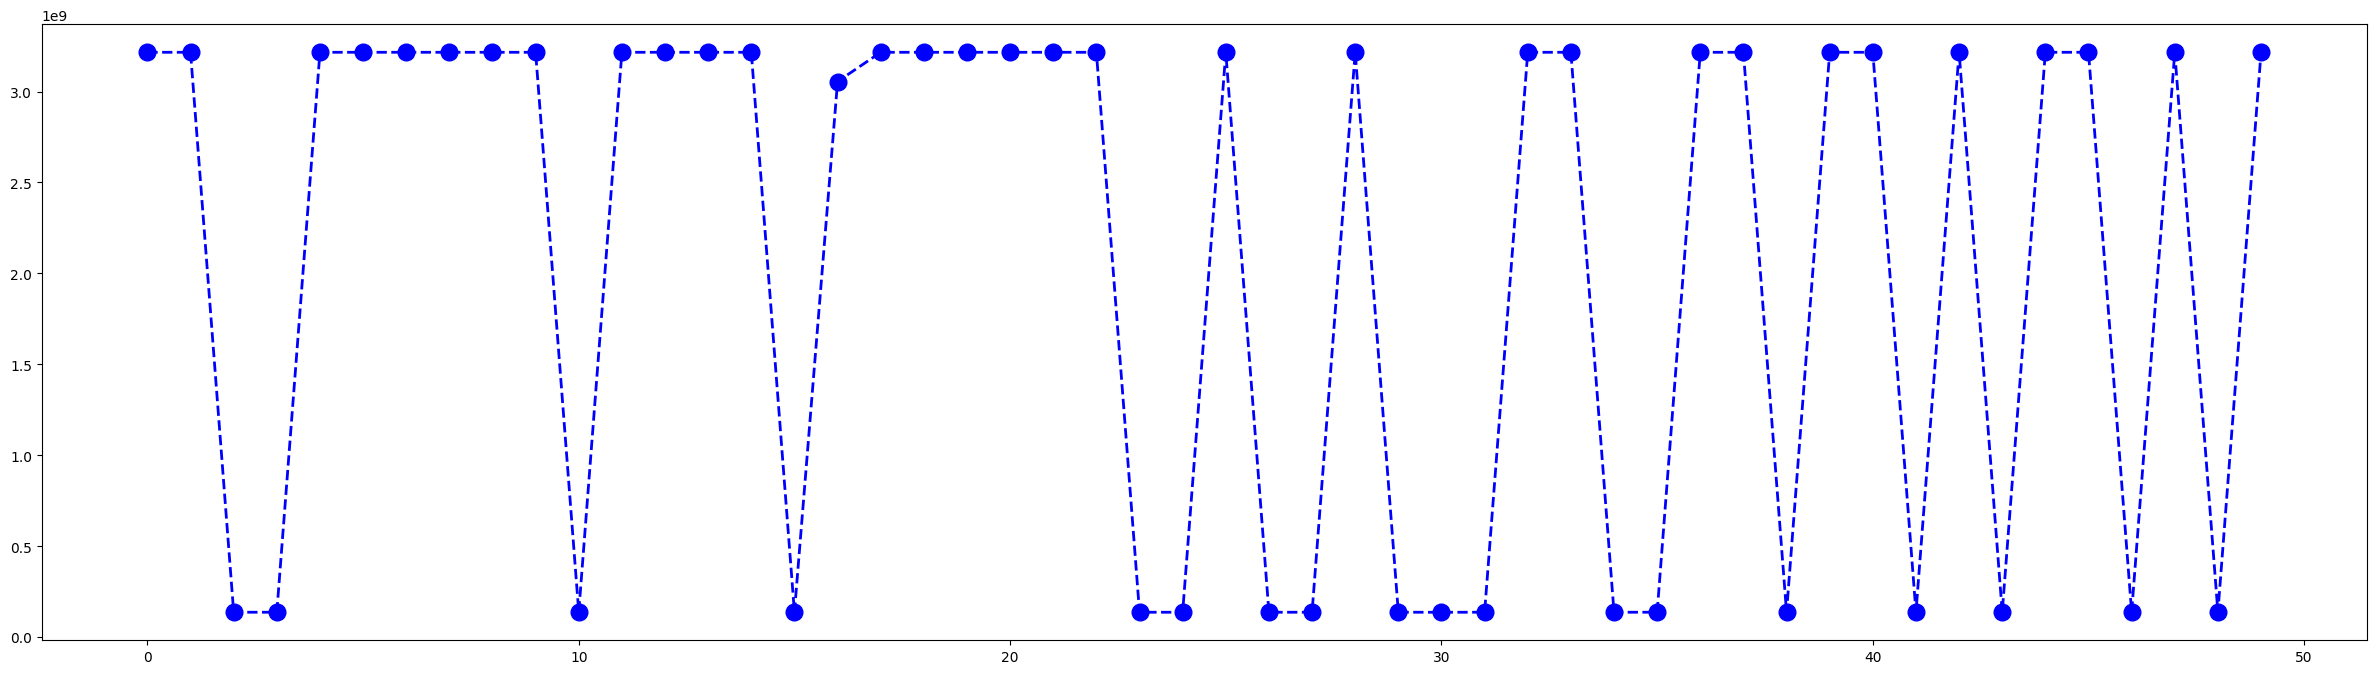

In [ ]:
x = [i for i in range(len(test_targets))]
plt.rcParams['figure.figsize'] = [30, 8]
plt.plot(x, test_data_targets['decimal_vals'], 'o--', color='b', linewidth=2, markersize=12)
plt.show

In [ ]:
#X_train, X_dev, y_train, y_dev = train_test_split(long_features, long_targets, test_size=0.2)
X_train, X_dev, y_train, y_dev = train_test_split(train_addrs, target_addrs, test_size=0.2)
X_train = np.array(X_train)
X_dev = np.array(X_dev)
y_train = np.array(y_train)
y_dev = np.array(y_dev)

### Normalise the data

#### MinMaxScaler

In [ ]:
# Create the scaler object
mm_x_scaler = MinMaxScaler()

# Fit the scaler to the training data
mm_x_scaler.fit(X_train)

# Use the scaler to transform the training and testing data
mm_X_train_scaled = mm_x_scaler.transform(X_train)
mm_X_dev_scaled = mm_x_scaler.transform(X_dev)

In [ ]:
# Create the scaler object
mm_y_scaler = MinMaxScaler()

# Fit the scaler to the training data
mm_y_scaler.fit(y_train.reshape(-1, 1))

# Use the scaler to transform the training and testing data
mm_y_train_scaled = mm_y_scaler.transform(y_train.reshape(-1, 1))
mm_y_dev_scaled = mm_y_scaler.transform(y_dev.reshape(-1, 1))

#### StandardScaler

In [ ]:
# x_data
# Create the scaler object
ss_x_scaler = StandardScaler()

# Fit the scaler to the training data
ss_x_scaler.fit(X_train)

# Use the scaler to transform the training and testing data
ss_X_train_scaled = ss_x_scaler.transform(X_train)
ss_X_dev_scaled = ss_x_scaler.transform(X_dev)

In [ ]:
# y_data
# Create the scaler object
ss_y_scaler = StandardScaler()

# Fit the scaler to the training data
ss_y_scaler.fit(y_train.reshape(-1, 1))

# Use the scaler to transform the training and testing data
ss_y_train_scaled = ss_y_scaler.transform(y_train.reshape(-1, 1))
ss_y_dev_scaled = ss_y_scaler.transform(y_dev.reshape(-1, 1))

## Model

### Importing the necessary Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

torch.manual_seed(1)

### Model Architecture

In [ ]:
class myLSTM(nn.Module):

    def __init__(self, n_hidden=500, n_layers=2, drop_prob=0.0, input_size=1, output_dim=1, batch_first =  True):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.output_dim = output_dim

        #lstm layer
        self.lstm = nn.LSTM(input_size, n_hidden, n_layers, dropout=drop_prob, batch_first=True)

        #output layer
        self.fc = nn.Linear(n_hidden, output_dim)

    def forward(self, x, h_t, c_t):
        ''' Forward pass through the network.
            These inputs are x, and the hidden/cell state `hidden`. '''

        #print(f"input shape: {x.shape}")
        #print(f"h_t shape: {h_t.shape}")
        #print(f"c_t shape: {c_t.shape}")

        ## Get the outputs and the new hidden state from the lstm
        lstm_out, _= self.lstm(x, (h_t, c_t))
        #print(f"lstm out: {lstm_out.shape}")

        # Stack up LSTM outputs using view
        #lstm_out = lstm_out.contiguous().view(batch_size, -1, self.n_hidden)

        ## put x through the fully-connected layer
        out = self.fc(lstm_out)
        #print("after fc")
        #print(f"out : {out.shape}")
        out = out[:, -1, :]
        #print(f"out : {out.shape}")
        return out

    def init_hidden(self, train):
        h_t = torch.zeros(self.n_layers, train.size(0), self.n_hidden)
        c_t = torch.zeros(self.n_layers, train.size(0), self.n_hidden)
        return h_t, c_t



In [ ]:
def model_train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        # print(X.shape)
        # print(y.shape)
        X = X.reshape(batch_size, 999, 1)
        h_t, c_t = model.init_hidden(X)
        pred = model(X, h_t, c_t)
        #print(pred.shape)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if(batch % 10 == 0):
            current = batch * len(X)
            #print(f"Batch: {batch}/{len(dataloader)}, Loss: {loss.item():.6f}, Current: {current}/{size}")
    print(f"Epoch {epoch + 1}, Training loss: {train_loss/len(dataloader):.6f}")


def test_model(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            h_t, c_t = model.init_hidden(X)
            pred = model(X, h_t, c_t)

            loss = loss_fn(pred, y)
            test_loss += loss.item()

    test_loss /= num_batches
    print(f"Epoch {epoch + 1}, Test loss: {test_loss:.6f}")

In [ ]:
# define and print the net
batch_size = 32
n_hidden = 64
n_layers = 2
lstm = myLSTM(n_hidden, n_layers)

print(lstm)

myLSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.001)
n_epochs =  150
hist = np.zeros(n_epochs)

In [ ]:
ss_X_train_scaled = ss_X_train_scaled.reshape(320, 999, 1)

In [ ]:
ss_X_dev_scaled = ss_X_dev_scaled.reshape(80, 999, 1)

In [ ]:
train_data = TensorDataset(torch.from_numpy(ss_X_train_scaled).float(), torch.from_numpy(ss_y_train_scaled).float())
val_data = TensorDataset(torch.from_numpy(ss_X_dev_scaled).float(), torch.from_numpy(ss_y_dev_scaled).float())
#test_data = TensorDataset(torch.from_numpy(test_sentences).float(), torch.from_numpy(test_labels).float())

In [ ]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=1)
#test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

#### Check on where will the train step will happen

### Train Step

In [ ]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_train(train_loader, lstm, criterion, optimizer, t)
    test_model(val_loader, lstm, criterion, t)
print("Done!")

Epoch 1
-------------------------------
Epoch 1, Training loss: 0.992449
Epoch 1, Test loss: 0.918844
Epoch 2
-------------------------------
Epoch 2, Training loss: 0.908539
Epoch 2, Test loss: 0.752592
Epoch 3
-------------------------------
Epoch 3, Training loss: 0.804059
Epoch 3, Test loss: 0.624541
Epoch 4
-------------------------------
Epoch 4, Training loss: 0.756096
Epoch 4, Test loss: 0.599533
Epoch 5
-------------------------------
Epoch 5, Training loss: 0.726400
Epoch 5, Test loss: 0.539467
Epoch 6
-------------------------------
Epoch 6, Training loss: 0.726761
Epoch 6, Test loss: 0.522694
Epoch 7
-------------------------------
Epoch 7, Training loss: 0.708746
Epoch 7, Test loss: 0.546700
Epoch 8
-------------------------------
Epoch 8, Training loss: 0.696490
Epoch 8, Test loss: 0.501491
Epoch 9
-------------------------------
Epoch 9, Training loss: 0.684332
Epoch 9, Test loss: 0.497930
Epoch 10
-------------------------------
Epoch 10, Training loss: 0.680248
Epoch 1

In [ ]:
y_pred_dev = []
with torch.no_grad():
    for X, y in val_loader:
        h_t, c_t = lstm.init_hidden(X)
        y_pred = lstm(X, h_t, c_t)
        y_pred = ss_y_scaler.inverse_transform(y_pred.detach().numpy())
        y_pred_dev.append(int(y_pred[0][0]))

In [ ]:
correct_pred_dev = []
for i, y in enumerate(y_dev):
    if y == y_pred_dev[i]:
        correct_pred_dev.append([y, i])
len(correct_pred_dev)

0